prompt:  load the parquet fies we created in the other two notebooks and perform
a regression to analyze the relationship between median income of a tract
(independent variable ) and the average download speeds (dependent variable ) in
that tract. You will need to do a spatial join on the two dataset, to locate
each point from the uss_mobile_2022q1 dataset to a census tract, then aggregate
by tract, computing the average or median download speed or upload speed. YOu
should create an analysis function to parameterize which statistic of central
tendencay we use, and which dependent variable we use. Use statsmodel for the OLS. 

## Updates

[ When you havve completed an update, put `[DONE]` in front of it, after the bullet. ]

* [DONE] You do not need to create Points from tile_x and til_y in the uss_mobile dataset, there is already a geometry field. You might have to use shapely.loads to convert that from a string to a geometry, but check first.

* [DONE] Aggregating the joined dataset:  average these fields: ['avg_d_kbps',
  'avg_u_kbps', 'avg_lat_ms', 'avg_lat_down_ms', 'avg_lat_up_ms']. sum these
  fields: ['tests', 'devices']. group by: 'GEOID'. There should be only one
  'median_income', and it should be passed through. 

In [12]:
 # Enable autoreload and import libraries
%load_ext autoreload
%autoreload 2

import pandas as pd
import geopandas as gpd
import statsmodels.api as sm
import matplotlib.pyplot as plt

# Load configuration
data_dir = None
%run ../../config.py


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Project root: /Users/eric/proj/wireless-income
Data directory: /Users/eric/proj/wireless-income/data


In [13]:
# Paths to parquet files produced by other notebooks
mobile_path = f"{data_dir}/uss_mobile_2022q1.parquet"
tracts_path = f"{data_dir}/tracts_with_income_2022.parquet"

# Load datasets
mobile_df = pd.read_parquet(mobile_path)
tracts_gdf = gpd.read_parquet(tracts_path)

# Convert mobile_df to GeoDataFrame using existing geometry field
import shapely.wkb

# Convert WKB geometry to shapely objects
mobile_df['geometry'] = mobile_df['geometry'].apply(lambda x: shapely.wkb.loads(x) if x else None)

# Create GeoDataFrame with existing geometry
mobile_gdf = gpd.GeoDataFrame(mobile_df, geometry='geometry', crs="EPSG:4326")

print(f"Mobile data rows: {len(mobile_gdf)}")
print(f"Tracts: {len(tracts_gdf)}")

# Reproject to a common CRS for spatial operations
mobile_gdf = mobile_gdf.to_crs(epsg=3857)
tracts_gdf = tracts_gdf.to_crs(epsg=3857)

# Spatial join: assign each speed point to a tract
joined = gpd.sjoin(mobile_gdf, tracts_gdf[["GEOID", "median_income", "geometry"]], how="inner", predicate="within")

print(f"Joined rows: {len(joined)}")
joined.head()

Mobile data rows: 2448
Tracts: 83225
Joined rows: 1522
Joined rows: 1522


,avg_d_kbps,avg_u_kbps,avg_lat_ms,avg_lat_down_ms,avg_lat_up_ms,tests,devices,geometry,index_right,GEOID,median_income
229050,62593,12265,27,NaN,NaN,6,1,POINT (-10765084.565 3911442.183),59325,48085031416,209040.0
23156,64199,18073,58,NaN,NaN,2,2,POINT (-13389018.547 6007643.307),9923,53017950800,78645.0
484176,30493,25821,36,NaN,NaN,1,1,POINT (-7867204.449 5125260.288),26413,25023545200,88300.0
75472,97835,25895,40,NaN,NaN,7,4,POINT (-10186612.832 5107517.618),43552,19103001700,62981.0
799026,20023,2882,43,NaN,NaN,2,1,POINT (-8619345.721 4694763.565),3309,51059491405,233563.0


                            OLS Regression Results                            
Dep. Variable:                      y   R-squared:                       0.005
Model:                            OLS   Adj. R-squared:                  0.004
Method:                 Least Squares   F-statistic:                     7.002
Date:                Sat, 29 Nov 2025   Prob (F-statistic):            0.00823
Time:                        06:46:06   Log-Likelihood:                -19941.
No. Observations:                1497   AIC:                         3.989e+04
Df Residuals:                    1495   BIC:                         3.990e+04
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       8.669e+04   9094.048      9.532      0.0

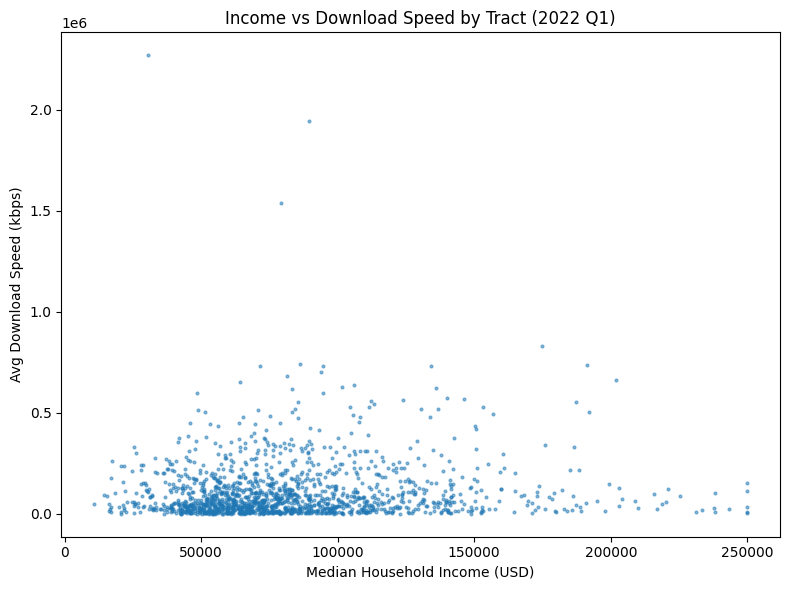

In [ ]:
# Aggregation function and OLS helper
import numpy as np

def aggregate_speeds(joined_gdf, by="GEOID", var="avg_d_kbps", stat="mean"):
    """
    Aggregate speeds by tract with chosen statistic.
    stat: 'mean' | 'median'
    var: column in joined_gdf for dependent variable (e.g., 'avg_d_kbps', 'avg_u_kbps')
    
    Aggregates:
    - Average: avg_d_kbps, avg_u_kbps, avg_lat_ms, avg_lat_down_ms, avg_lat_up_ms
    - Sum: tests, devices
    - Pass through: median_income
    """
    agg_dict = {
        'avg_d_kbps': stat,
        'avg_u_kbps': stat,
        'avg_lat_ms': stat,
        'avg_lat_down_ms': stat,
        'avg_lat_up_ms': stat,
        'tests': 'sum',
        'devices': 'sum',
        'median_income': 'first'
    }
    
    agg = joined_gdf.groupby(by).agg(agg_dict).reset_index()
    
    # Rename the dependent variable to 'y' and median_income to 'x' for OLS
    agg.rename(columns={var: "y", "median_income": "x"}, inplace=True)
    return agg


def run_ols(df):
    """Run OLS: y ~ x using statsmodels."""
    X = sm.add_constant(df["x"])  # add intercept
    y = df["y"]
    model = sm.OLS(y, X, missing="drop").fit()
    return model

# Example: aggregate using mean download speed and run OLS
agg_df = aggregate_speeds(joined, var="avg_d_kbps", stat="mean")
model = run_ols(agg_df)
print(model.summary())

# Quick scatter plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.scatter(agg_df["x"], agg_df["y"], s=4, alpha=0.5)
ax.set_xlabel("Median Household Income (USD)")
ax.set_ylabel("Avg Download Speed (kbps)")
ax.set_title("Income vs Download Speed by Tract (2022 Q1)")
plt.tight_layout()
plt.show()

In [17]:
agg_df.head()

,GEOID,y,x
0,01003011413,4446.0,59628.0
1,01003011601,6153.0,54439.0
2,01043965600,2171.0,67679.0
3,01055010300,37144.0,43698.0
4,01067030500,59368.0,80324.0
